# Lab Sheet 4-5: More Text Classification, Semi-structured text processing and DataFrames

These tasks are for working in the lab session and during the week. We'll build on last weeks code and add some classification. 

For this lab, we are going to use a simple text classification problem as an example to build an ML pipeline in Spark MLlib, inspect it if it doesn't work as expected, and tune hyperparameters. We will also do some web scraping and 




## PART 1 - LAB
## 1) Dataset: Newsgroups

Now we use anoter, larger dataset, which consists of 'usenet' discussions from the early days of the Internet. This dataset contains messages from 20 different newsgroups on different topics with ~1000 messages each. More information and the data can be found here here:

[http://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/](http://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/)

With the larger dataset you should get more meaningful time measurements. Try several runs and try executing things in different oder (here we are only training a LR classifier, however you are encouraged to try other models). 
To create a meaningful dataset for classification, you need read in at least 2 topics and then use `RDD.randomSplit()`. For this lab , we will use alt.atheism and comp.graphics. Try adding more topics to the dataset, there are 20 differet directories (i.e. topics).


To download and unpack the data, use the following code:

In [10]:
%cd ~/notebook/work/City-Data-Science/datasets/
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/20_newsgroups.tar.gz
!ls

/gpfs/global_fs01/sym_shared/YPProdSpark/user/sb1c-2a2fc727357cc3-3b10766cfe3e/notebook/work/City-Data-Science/datasets
--2018-04-08 17:40:17--  http://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/20_newsgroups.tar.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17332201 (17M) [application/x-gzip]
Saving to: ‘20_newsgroups.tar.gz.16’

100%[======================================>] 17,332,201  4.65MB/s   in 4.1s   

2018-04-08 17:40:21 (3.98 MB/s) - ‘20_newsgroups.tar.gz.16’ saved [17332201/17332201]

20_newsgroups		 20_newsgroups.tar.gz.14  20_newsgroups.tar.gz.6
20_newsgroups.tar.gz	 20_newsgroups.tar.gz.15  20_newsgroups.tar.gz.7
20_newsgroups.tar.gz.1	 20_newsgroups.tar.gz.16  20_newsgroups.tar.gz.8
20_newsgroups.tar.gz.10  20_newsgroups.tar.gz.2   20_newsgroups.tar.gz.9
20_newsgroups.tar.gz.11  

In [11]:
!tar -xf 20_newsgroups.tar.gz
# '!' calls a program on the machine (the DSX service runs on virtual Linux machines).
print(">>> Unzipping finished.")

>>> Unzipping finished.


In [12]:
!pwd

/gpfs/global_fs01/sym_shared/YPProdSpark/user/sb1c-2a2fc727357cc3-3b10766cfe3e/notebook/work/City-Data-Science/datasets


In [5]:
!echo "datasets/20_newsgroups/**" >> ~/notebook/work/City-Data-Science/.git/info/exclude
# add the newly created directory to the list of excluded dirs to prevent accidental uploading to github
# do this only once

In [13]:
%cd 20_newsgroups/ 
# go into the new directory
%ls # and show its content

/gpfs/global_fs01/sym_shared/YPProdSpark/user/sb1c-2a2fc727357cc3-3b10766cfe3e/notebook/work/City-Data-Science/datasets/20_newsgroups
alt.atheism/               rec.autos/           sci.space/
comp.graphics/             rec.motorcycles/     soc.religion.christian/
comp.os.ms-windows.misc/   rec.sport.baseball/  talk.politics.guns/
comp.sys.ibm.pc.hardware/  rec.sport.hockey/    talk.politics.mideast/
comp.sys.mac.hardware/     sci.crypt/           talk.politics.misc/
comp.windows.x/            sci.electronics/     talk.religion.misc/
misc.forsale/              sci.med/


In [14]:
from pyspark.ml import *
from pyspark.ml.classification import *
from pyspark.ml.feature import *
from pyspark.ml.param import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *
from pyspark.sql import *
import pixiedust
from pyspark.sql.types import Row
from pyspark.sql import SQLContext


SparkContext.version

sqlContext = SQLContext(sc)
spark = SparkSession.builder.getOrCreate()

import os.path
%cd ~
p = os.path.abspath('./notebook/work/City-Data-Science/datasets/20_newsgroups/')
print("p: ", p) # we need the path, as the executors that will read the from directories, will not run in the same environment, so that %cd calls don't help

#here we are setting the path to select 2 topics
#dirPath1 = p + '/alt.atheism'
dirPath1 = p + '/sci.crypt'
dirPath2 = p + '/comp.graphics'

# Use wholeTextFiles to read both the files
alt_rdd = sc.wholeTextFiles(dirPath1)
comp_rdd = sc.wholeTextFiles(dirPath2)

alt_rdd.take(1)
comp_rdd.take(1)

#Create a union of the 2 RDD's so we hava a full set
newsGroup_RDD = alt_rdd.union(comp_rdd)

#printing the total number of documents here:
print ('Number of documents read is:',newsGroup_RDD.count())

/gpfs/global_fs01/sym_shared/YPProdSpark/user/sb1c-2a2fc727357cc3-3b10766cfe3e
p:  /gpfs/global_fs01/sym_shared/YPProdSpark/user/sb1c-2a2fc727357cc3-3b10766cfe3e/notebook/work/City-Data-Science/datasets/20_newsgroups


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 4.0 failed 10 times, most recent failure: Lost task 0.9 in stage 4.0 (TID 49, yp-spark-dal09-env5-0025, executor 4db91256-7293-4020-a33f-3d65b78293ef): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/src/spark21master/spark-2.1.2-bin-2.7.3/python/lib/pyspark.zip/pyspark/worker.py", line 160, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/usr/local/src/spark21master/spark-2.1.2-bin-2.7.3/python/lib/pyspark.zip/pyspark/worker.py", line 54, in read_command
    command = serializer._read_with_length(file)
  File "/usr/local/src/spark21master/spark-2.1.2-bin-2.7.3/python/lib/pyspark.zip/pyspark/serializers.py", line 169, in _read_with_length
    return self.loads(obj)
  File "/usr/local/src/spark21master/spark-2.1.2-bin-2.7.3/python/lib/pyspark.zip/pyspark/serializers.py", line 455, in loads
    return pickle.loads(obj, encoding=encoding)
  File "/usr/local/src/spark21master/spark-2.1.2-bin-2.7.3/python/lib/pyspark.zip/pyspark/cloudpickle.py", line 783, in _make_skel_func
    closure = _reconstruct_closure(closures) if closures else None
  File "/usr/local/src/spark21master/spark-2.1.2-bin-2.7.3/python/lib/pyspark.zip/pyspark/cloudpickle.py", line 775, in _reconstruct_closure
    return tuple([_make_cell(v) for v in values])
TypeError: 'int' object is not iterable

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:326)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:290)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:326)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1153)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.lang.Thread.run(Thread.java:785)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1442)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1430)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1429)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1429)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:803)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:803)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:803)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1657)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1612)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1601)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at java.lang.Thread.getStackTrace(Thread.java:1117)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:629)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1941)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1954)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1967)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:441)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:95)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:55)
	at java.lang.reflect.Method.invoke(Method.java:507)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:785)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/src/spark21master/spark-2.1.2-bin-2.7.3/python/lib/pyspark.zip/pyspark/worker.py", line 160, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/usr/local/src/spark21master/spark-2.1.2-bin-2.7.3/python/lib/pyspark.zip/pyspark/worker.py", line 54, in read_command
    command = serializer._read_with_length(file)
  File "/usr/local/src/spark21master/spark-2.1.2-bin-2.7.3/python/lib/pyspark.zip/pyspark/serializers.py", line 169, in _read_with_length
    return self.loads(obj)
  File "/usr/local/src/spark21master/spark-2.1.2-bin-2.7.3/python/lib/pyspark.zip/pyspark/serializers.py", line 455, in loads
    return pickle.loads(obj, encoding=encoding)
  File "/usr/local/src/spark21master/spark-2.1.2-bin-2.7.3/python/lib/pyspark.zip/pyspark/cloudpickle.py", line 783, in _make_skel_func
    closure = _reconstruct_closure(closures) if closures else None
  File "/usr/local/src/spark21master/spark-2.1.2-bin-2.7.3/python/lib/pyspark.zip/pyspark/cloudpickle.py", line 775, in _reconstruct_closure
    return tuple([_make_cell(v) for v in values])
TypeError: 'int' object is not iterable

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:326)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:290)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:326)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1153)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [8]:
#Split the filename and content
#You can use the splitFileWords function from Lab 3
#This function will help split the filename and content

import re 
    
def splitFileWords(filenameContent): # your splitting function
    f,c = filenameContent # split the input tuple  
    fwLst = [] # the new list for (filename,word) tuples
    wLst = re.split('\W+',c) # <<< now create a word list wLst
    for w in wLst : # iterate through the list
        fwLst.append((f,w)) # and append (f,w) to the 
    return fwLst #return a list of (f,w) tuples


# Remove the file name and path before the last directory name (i.e. the newsgroup name) 
fnt_RDD = newsGroup_RDD.map(lambda ft: (re.split('[/]',ft[0])[-2],ft[1]))
print(fnt_RDD.take(2)) 

[('alt.atheism', 'Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!bogus.sura.net!news-feed-1.peachnet.edu!umn.edu!uum1!mac.cc.macalstr.edu!acooper\nFrom: acooper@mac.cc.macalstr.edu (Turin Turambar, ME Department of Utter Misery)\nNewsgroups: alt.atheism\nSubject: Re: free moral agency\nMessage-ID: <1993Apr20.185237.4924@mac.cc.macalstr.edu>\nDate: 20 Apr 93 18:52:37 -0600\nReferences: <1quuaa$6s@eagle.lerc.nasa.gov> <735295730.25282@minster.york.ac.uk>\nDistribution: world\nOrganization: Macalester College\nLines: 19\n\nIn article <735295730.25282@minster.york.ac.uk>, cjhs@minster.york.ac.uk writes:\n> : Are you saying that their was a physical Adam and Eve, and that all\n> : humans are direct decendents of only these two human beings.?  Then who\n> : were Cain and Able\'s wives?  Couldn\'t be their sisters, because A&E\n> : didn\'t have daughters.  Were they non-humans?\n> \n> Genesis 5:4\n

## 2) Preprocessing: Remove the headers from the files

At closer inspection, we can see that the messages have headers, and one of them starts with 'Newsgroups:' and actually lists the topic. This is clearly an unreasonable shortcut for the classifier, as we are interested in predicting topics from the text.  

Thus, the dataset needs preprocessing to remove these headers. We can use a regular expression to remove the header. 

In [24]:
import re

# new function to remove the headers using regular expressions
def removeHeader(ft): 
    fn,text = ft # unpack the filename and text content 
    # now use a regular expression to match the text
    # When you check the data, you can see that the first line that 
    # starts with 'Lines:' normally ends the headers. 
    # Only the very first file is different, but we can tolerate one wrong sample for now. 
    # (How could we be more thorough?)
#>>> matchObj = re.match()  ..  #fill in the expression here   
    matchObj = re.match(r'.+^Lines:(.*)', text, re.MULTILINE|re.DOTALL) 
    if(matchObj): # only if the pattern has matched 
        text = matchObj.group(1) # can we replace the text, 
        #otherwise we keep the old for now (what could be a better solution?)
    return (fn,text)

fnt_RDD2 = fnt_RDD.map(removeHeader)
fnt_RDD2.take(3)

[('alt.atheism',
  'Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!bogus.sura.net!news-feed-1.peachnet.edu!umn.edu!uum1!mac.cc.macalstr.edu!acooper\nFrom: acooper@mac.cc.macalstr.edu (Turin Turambar, ME Department of Utter Misery)\nNewsgroups: alt.atheism\nSubject: Re: free moral agency\nMessage-ID: <1993Apr20.185237.4924@mac.cc.macalstr.edu>\nDate: 20 Apr 93 18:52:37 -0600\nReferences: <1quuaa$6s@eagle.lerc.nasa.gov> <735295730.25282@minster.york.ac.uk>\nDistribution: world\nOrganization: Macalester College\nLines: 19\n\nIn article <735295730.25282@minster.york.ac.uk>, cjhs@minster.york.ac.uk writes:\n> : Are you saying that their was a physical Adam and Eve, and that all\n> : humans are direct decendents of only these two human beings.?  Then who\n> : were Cain and Able\'s wives?  Couldn\'t be their sisters, because A&E\n> : didn\'t have daughters.  Were they non-humans?\n> \n> Genesis 5:4

## 3) DataFrames

In this section we will introduce Dataframes. To read more on DataFrames look here:
https://spark.apache.org/docs/latest/sql-programming-guide.html

In Spark we can create Datframes from RDDs and that is what we will implement in the next section. 
A dataframe represents a table structure. We defined a schema that contains the names and types of the coumns in the table.

From the official documentation:

A Datframe can be created programatically in 3 steps:

- Create an RDD of Rows from the original RDD;
- Create the schema represented by a StructType matching the structure of Rows in the RDD created in Step 1.
- Apply the schema to the RDD of Rows via createDataFrame method provided by SparkSession.

More on pyspark API can be found here:

http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html



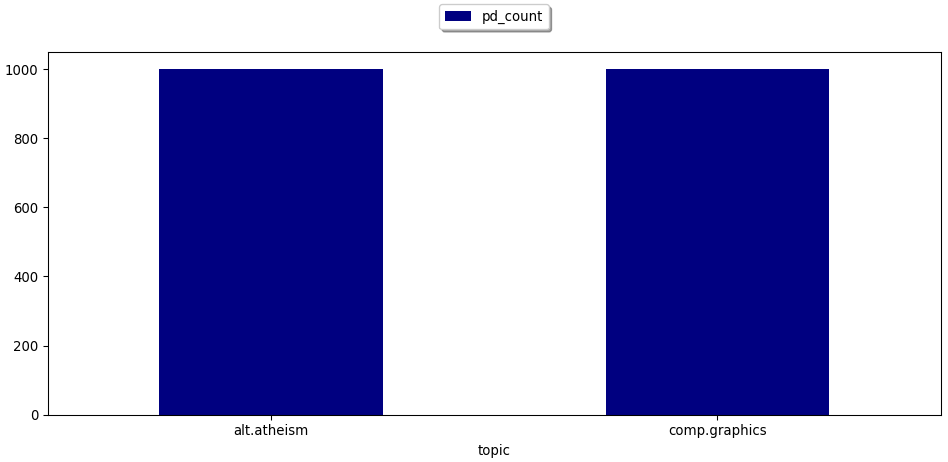

In [19]:
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# The schema is encoded in a string.
#Here we are only interested in the topic and text
schemaString = "topic text"

# A StructField object comprises three fields, name (a string), dataType (a DataType) and nullable (a bool). 
# We create 2 fields of strings with names according to our schemaString
fields = [StructField(field_name, StringType(), True) for field_name in schemaString.split()]
# these together define our schema
schema = StructType(fields)

print(fnt_RDD.take(1))
# Apply the schema in createDataFrame, to create a DataFrame 'df' from the RDD
df = sqlContext.createDataFrame(fnt_RDD, schema)

#print the schema of our DataFrame
df.printSchema()

#Use pixiedust to show the number of topics by frequency
#there are only 2 topics here, so lets see them
display(df.select('topic'))

In [20]:
# Create a (temporary) view using the DataFrame, so that we can us use SparkSQL.
df.createOrReplaceTempView("newsgroups")

# SQL can now be run on the DataFrame. 
# Let's start by selecting only the topics elements of each row 
results = sqlContext.sql("SELECT DISTINCT topic FROM newsgroups")
results.show()

+-------------+
|        topic|
+-------------+
|comp.graphics|
|  alt.atheism|
+-------------+



In [21]:
# We can make more sophisticated queries in SQL, e.g. using  topic names as a distinct feature and simply count number of files
results_topic = sqlContext.sql("SELECT DISTINCT topic, count(*) as cnt FROM newsgroups GROUP BY topic ORDER BY cnt DESC")
results_topic.show()

+-------------+----+
|        topic| cnt|
+-------------+----+
|  alt.atheism|1000|
|comp.graphics|1000|
+-------------+----+



We need numeric labels for the classifier, for now we go for binary labels. 

In [22]:
# df.withColumn Returns a new DataFrame by adding a column with a name and value for each row.
# The value is a 'column expression', where we compares with the string 'comp', to find out whether the topic is about computing.
# double - will convert the resulting Boolean value into a number
news_Groups = df.withColumn("label",df.topic.like("comp%").cast("double"))

# you can use a syntax similar to an array to select some examples of either class 
alt_topic_df = news_Groups[df.topic.like("alt%")]
alt_topic_df.show(3)
# >>> Do the same for comp% 
comp_topic_df = news_Groups[df.topic.like("comp%")]
comp_topic_df.show(3)

+-----------+--------------------+-----+
|      topic|                text|label|
+-----------+--------------------+-----+
|alt.atheism|Path: cantaloupe....|  0.0|
|alt.atheism|Newsgroups: alt.a...|  0.0|
|alt.atheism|Newsgroups: alt.a...|  0.0|
+-----------+--------------------+-----+
only showing top 3 rows

+-------------+--------------------+-----+
|        topic|                text|label|
+-------------+--------------------+-----+
|comp.graphics|Newsgroups: comp....|  1.0|
|comp.graphics|Xref: cantaloupe....|  1.0|
|comp.graphics|Newsgroups: comp....|  1.0|
+-------------+--------------------+-----+
only showing top 3 rows



In [23]:
#Create the training and testing set from the dataframe above
#randomSplit - splits the Df into training/testing using the weights 
#you can try other combinations of weights
train_set, test_set = news_Groups.randomSplit([0.6, 0.4], 123)
print ("Total document count:",news_Groups.count())
print ("Training-set count:",train_set.count())
print ("Test-set count:",test_set.count())

Total document count: 2000
Training-set count: 1191
Test-set count: 809


## 4) Using ML to classify messages 

ML is the Spark machine learning library for DataFrames. We want to build an ML pipeline to predict the Binary label.

A Spark ML Pipeline is a sequence of stages, and each stage is either a Transformer or an Estimator. These stages are run in order, and the input DataFrame is transformed as it passes through each stage.

A practical ML pipeline might consist of many stages like feature extraction, feature transformation, and model fitting. We use  pipeline that consists of the following stages:

    a)RegexTokenizer - which tokenizes each article into a sequence of words with a regex pattern,
    b)HashingTF, which maps the word sequences produced by RegexTokenizer to sparse feature vectors using the hashing trick,
    c)LogisticRegression, which fits the feature vectors and the labels from the training data to a logistic regression model.
    
To read more on this:

https://spark.apache.org/docs/2.1.0/ml-features.html



In [26]:
from pyspark.ml.linalg import Vector
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF,StopWordsRemover,IDF,Tokenizer

#Constructing a pipeline
#We split each sentence into words using Tokenizer. 
#Tokenizer only splits by white spaces
tokenizer = Tokenizer().setInputCol("text").setOutputCol("words")

#Remove stopwords
remover= StopWordsRemover().setInputCol("words").setOutputCol("filtered").setCaseSensitive(False)

#For each sentence (bag of words),use HashingTF to hash the sentence into a feature vector. 
hashingTF = HashingTF().setNumFeatures(1000).setInputCol("filtered").setOutputCol("rawFeatures")

#We use IDF to rescale the feature vectors; this generally improves performance when using text as features.
idf = IDF().setInputCol("rawFeatures").setOutputCol("features").setMinDocFreq(0)

#Our feature vectors could then be passed to a learning algorithm.
# Create a Logistic regression model
lr = LogisticRegression()
#nb = NaiveBayes()

#Then basically we connect all the steps above to create one pipeline
pipeline=Pipeline(stages=[tokenizer,remover,hashingTF,idf, lr])

In [92]:
#We can get an information for each parameter  using the .explainParams()
print ("Tokenizer:",tokenizer.explainParams())
print("/n/n")

#Use the same function as above to get details for Remover, Hashing TF , IDF and Pipeline
>>>print ("Remover:",......)
print("/n/n")
>>>print ("HashingTF:",......)
print ("/n/n")
>>>print ("IDF:",.......)
print("/n/n")

>>>print ("Pipeline:",.......)
print("/n/n")


Tokenizer: inputCol: input column name. (current: text)
outputCol: output column name. (default: Tokenizer_42f0be3eb4c8e2df2abc__output, current: words)
/n/n
Remover: caseSensitive: whether to do a case sensitive comparison over the stop words (default: False, current: False)
inputCol: input column name. (current: words)
outputCol: output column name. (default: StopWordsRemover_4874a9e0896073939620__output, current: filtered)
stopWords: The words to be filtered out (default: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'a

In [93]:
#Use the pipeline option to fit the training set and create a model

# Jupyter offers a simpler way to take the time thanwe used in the coursework. 
%time

# After we construct this ML pipeline,we can fit it to the training data
# and obtain a trained pipeline model that can be used for prediction.
model=pipeline.fit(train_set)

CPU times: user 7 µs, sys: 3 µs, total: 10 µs
Wall time: 19.3 µs


## 4) Evaluate prediction results

In [94]:
#After we obtain a fitted pipeline model, we want to know how well it performs. 
#Let us start with some manual checks by displaying the predicted labels.

#You can simply use the .transform() on the test set to make predictions on the test set
test_predictions = model.transform(test_set)
train_predictions = model.transform(train_set)

#Show the predicted labels along with true labels and raw texts.
test_predictions.select("topic","probability","prediction","label").show(5)
# and show some of the other class ...in our case for comp%
>>> test_predictions.select("topic","probability","prediction","label").filter(..............).show(5)


+-----------+--------------------+----------+-----+
|      topic|         probability|prediction|label|
+-----------+--------------------+----------+-----+
|alt.atheism|[0.99999999999987...|       0.0|  0.0|
|alt.atheism|[0.99999933900794...|       0.0|  0.0|
|alt.atheism|[0.08125659188165...|       1.0|  0.0|
|alt.atheism|           [1.0,0.0]|       0.0|  0.0|
|alt.atheism|[4.11055589470913...|       1.0|  0.0|
+-----------+--------------------+----------+-----+
only showing top 5 rows

+-------------+--------------------+----------+-----+
|        topic|         probability|prediction|label|
+-------------+--------------------+----------+-----+
|comp.graphics|[9.23259183148201...|       1.0|  1.0|
|comp.graphics|[7.01056035665729...|       1.0|  1.0|
|comp.graphics|[3.41028828737437...|       1.0|  1.0|
|comp.graphics|[1.63245286744783...|       1.0|  1.0|
|comp.graphics|[1.56693132031322...|       1.0|  1.0|
+-------------+--------------------+----------+-----+
only showing top 5 ro

In [95]:
#The predicted labels look accurate. 
#Let's evaluate the model quantitatively.

evaluator = BinaryClassificationEvaluator().setMetricName("areaUnderROC")
print ("Area under ROC curve - training:",evaluator.evaluate(train_predictions))
print ("Area under ROC curve - testing:",evaluator.evaluate(test_predictions))

Area under ROC curve - training: 1.0
Area under ROC curve - testing: 0.9627293507890521


The training result is already perfect, the test result is also excellent. So, this task is easy for LogisticRegression. With 20 classes, the task gets harder however. 

## Extra Tasks

These tasks are a bit more involved in terms of programming and 

## Multi- class classification

Use all the 20 toics in the dataset as class labels. The reading of the data is straightforward. You will need to use a different mapping from newsgroup names to class labels, though. Then you will need a different evaluation, as the ROC AUC is only defined for the binary case. 

The perfomance will be lower, so that it is worth to try and tune the hyper-parameters. 

## Tuning the Hyper-Parameters

In [96]:
#We use a ParamGridBuilder to construct a grid of parameters to search over.

#With 3 values for hashingTF.numFeatures and 3 values for idf,
# this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from.

paramGrid = ParamGridBuilder()\
    .addGrid(hashingTF.numFeatures,[1000,10000,100000])\
    .addGrid(idf.minDocFreq,[0,10,100])\
    .build()

In [ ]:
#A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.

cv = CrossValidator().setEstimator(pipeline).setEvaluator(evaluator).setEstimatorParamMaps(paramGrid).setNumFolds(2)
# Note: This takes a long time to run
# Do this step only when you've done everything else first!
%%time
cvModel = cv.fit(train_set)
print("Area under the ROC curve for best fitted model =",evaluator.evaluate(cvModel.transform(test_set)))

In [ ]:
#Task:
# After you have run the cell above , print both results (with and without cross validation)
#Observe the results
>>> Print results for both 
print ("Area under ROC curve for non-tuned model:",........)  <<< fill in here
print ("Area under ROC curve for fitted model:",.............) <<< fill in here

## PART 2 



## 7)Analysing XML Data

You can complete the first section and come to this later on.


These tasks are for working in the lab session and during the week. Unlike previous labs, these tasks do not build on previous labs directly, but use the skills you have learned so far on a new XML dataset. 

To get different datasets, use the link below and once you get the code working for one dataset, you can then try and experiment with the remaing sets.

http://ratings.food.gov.uk/open-data/



## 7a)   Using the XML parser
We start by reading the dataset into and parsing it using the ElementTree parser. 
The XML looks like this: 

`<FHRSEstablishment>
    <Header>
    <ExtractDate>2015-11-06</ExtractDate>
    <ItemCount>1256</ItemCount>
    <ReturnCode>Success</ReturnCode>
    </Header>
    <EstablishmentCollection>
        <EstablishmentDetail>
        <FHRSID>507136</FHRSID>
        <LocalAuthorityBusinessID>PI/000081182</LocalAuthorityBusinessID>
        <BusinessName>196</BusinessName>
        <BusinessType>Restaurant/Cafe/Canteen</BusinessType>
        <BusinessTypeID>1</BusinessTypeID>
        <AddressLine1>Cambridge</AddressLine1>
        <AddressLine2>Cambridgeshire</AddressLine2>
        <PostCode>CB1 3NF</PostCode>
        <RatingValue>5</RatingValue>
        <RatingKey>fhrs_5_en-GB</RatingKey>
        <RatingDate>2015-01-22</RatingDate>
        <LocalAuthorityCode>027</LocalAuthorityCode>
        <LocalAuthorityName>Cambridge City</LocalAuthorityName>
            <LocalAuthorityWebSite>http://www.cambridge.gov.uk</LocalAuthorityWebSite>
            <LocalAuthorityEmailAddress>env.health@cambridge.gov.uk</LocalAuthorityEmailAddress>
        <Scores>
            <Hygiene>5</Hygiene>
            <Structural>0</Structural>
            <ConfidenceInManagement>5</ConfidenceInManagement>
        </Scores>
        <SchemeType>FHRS</SchemeType>
        <NewRatingPending>False</NewRatingPending>
        <Geocode>
            <Longitude>0.14503300000000</Longitude>
            <Latitude>52.19734500000000</Latitude>
        </Geocode>
    </EstablishmentDetail>`
    

## 8) Get the XML Data


The predefined `parseXML` function creates an XML parse tree for you. Start creating an RDD that contains just the parse trees instead of text. Then filter out the files that could not be parsed.
 
We provide the code for using ElementTree, but it's worth having a look for more info here: [https://docs.python.org/3.5/library/xml.etree.elementtree.html](https://docs.python.org/3.5/library/xml.etree.elementtree.html).





In [60]:
#Get the data

%cd ~/notebook/work/City-Data-Science/
!git clone https://github.com/tweyde/City-Data-Science.git


/gpfs/global_fs01/sym_shared/YPProdSpark/user/s832-dfe96c6e1f1d61-70d619a53771/notebook/work
fatal: destination path 'City-Data-Science' already exists and is not an empty directory.


In [62]:
!git pull
%cd datasets/
%ls

remote: Counting objects: 6, done.
remote: Total 6 (delta 2), reused 2 (delta 2), pack-reused 4
Unpacking objects: 100% (6/6), done.
From https://github.com/tweyde/City-Data-Science
   ddd2162..5593edd  master     -> origin/master
Updating ddd2162..5593edd
Fast-forward
 datasets/foodhygiene.zip | Bin 0 -> 31777575 bytes
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 datasets/foodhygiene.zip
/gpfs/global_fs01/sym_shared/YPProdSpark/user/s832-dfe96c6e1f1d61-70d619a53771/notebook/work/City-Data-Science/datasets
20_newsgroups/        20_newsgroups.tar.gz.1  lingspam_public/
20_newsgroups.tar.gz  foodhygiene.zip         lingspam_public02.tar.gz


In [69]:
!rm -R foodhygiene
!unzip -q foodhygiene.zip
%ls
!echo "datasets/foodhygiene/**" >> ~/notebook/work/City-Data-Science/.git/info/exclude
# add the newly created directory to the list of excluded dirs to prevent accidental uploading to github
# do this only once

20_newsgroups/          foodhygiene/      lingspam_public02.tar.gz
20_newsgroups.tar.gz    foodhygiene.zip
20_newsgroups.tar.gz.1  lingspam_public/


In [71]:
import xml.etree.ElementTree as ET

def parseXML(f_x):
    try:
        root = ET.fromstring(f_x[1])
    except ET.ParseError as err:
        # parsing error :-(
        root = None
    return (f_x[0], root)

%cd ~
p = os.path.abspath('./notebook/work/City-Data-Science/datasets/foodhygiene')
rawData = sc.wholeTextFiles(p)
parsedData = rawData.map(lambda ........) #<<<< map to XML parse trees
parsedData = parsedData.filter(lambda .......) #<<< filter out items where the parse tree is `None`
print(parsedData.take(1)) 

/gpfs/global_fs01/sym_shared/YPProdSpark/user/s832-dfe96c6e1f1d61-70d619a53771
[('file:/gpfs/global_fs01/sym_shared/YPProdSpark/user/s832-dfe96c6e1f1d61-70d619a53771/notebook/work/City-Data-Science/datasets/foodhygiene/FHRS524en-GB.xml', <Element 'FHRSEstablishment' at 0x7f52b5fd2f48>)]


## 9) Find establishements with valid hygiene ratings

Find all the possible RatingValue elements. For that we use the ElementTree function `findall`. We use a syntax called XPath, which enables us to find elements lower down in the tree without explicitly traversing it. The XPath syntax ist shown here: [https://docs.python.org/3.5/library/xml.etree.elementtree.html?highlight=elementtree#supported-xpath-syntax](https://docs.python.org/3.5/library/xml.etree.elementtree.html?highlight=elementtree#supported-xpath-syntax)

For finding the rating values, use `element.findall('.//RatingValue')` where element shoudl be the root of a parse tree. This gives a list of XML elements `x`, where we are interested in their `x.text` property.

In [72]:
allRatings = parsedData.flatMap(lambda f_et: [x.text for x in f_et[1].findall('.//RatingValue')]).distinct() #<<< find distnct values
allRatings.collect()

['4',
 '1',
 'Pass',
 'Pass and Eat Safe',
 'Awaiting Inspection',
 '0',
 'AwaitingPublication',
 'Improvement Required',
 'AwaitingInspection',
 'Exempt',
 '5',
 '3',
 '2']

## 10) Remove non-numeric ratings

Now we want to get rid of the non-numeric ratings. These should be:

    invalidRatings = ['Pass','Pass and Eat Safe','Awaiting Inspection','AwaitingPublication','Improvement Required','AwaitingInspection','Exempt']
    
    
First collect all XML elements tagged EstablishmentDetail (with finall as before), but keep the elements for further use (i.e. don't extract the text element as above).


In [73]:
invalidRatings = ['Pass','Pass and Eat Safe','Awaiting Inspection','AwaitingPublication','Improvement Required','AwaitingInspection','Exempt']

allEstData = parsedData.flatMap(lambda f_et: f_et[1].findall('.//EstablishmentDetail')) #<<< get the establishment detail
print(allEstData.count()) # should be 497835

estData = allEstData.filter(lambda est: est.find('RatingValue').text not in invalidRatings)
print(estData.count()) # should be 411554

497835
411554


## 11) Find highest and lowest values

Find the 10 local authorities with the highest and lowest mean hygiene rating. We now use find as there is only one local authority per establishment, which we use as key. We then get the RatingValue and average (not in reduce, so associativity is not required here).

In [ ]:
from operator import add

import numpy as np
authRatings = estData.map(lambda est: 
    (est.find('LocalAuthorityName').text, 
    [float(est.find('RatingValue').text)])).reduceByKey(add).map(lambda a_rl: (a_rl[0], np.mean(a_rl[1])))

authRatings.... # using RDD.sortBy() get the 10 highest 
authRatings.... # using RDD.sortBy() get the 10 lowest 



## 12) Organise by PostCode
Use the first part of the PostCode node (i.e. for IP7 5BY, only use IP7) to find the best and worse postcodes for food hygiene.


In [86]:
authRatings = estData.map(lambda est: 
    # organize by PostCode instead of LocalAuthority
    (0 if est.find('PostCode') is None else est.find('PostCode').text, 
    [float(est.find('RatingValue').text)])).reduceByKey(add).map(lambda a_rl: (a_rl[0], np.mean(a_rl[1])))
# output as above
>>>
>>>

[('WF2 7EQ', 5.0), ('HD1 6EE', 5.0), ('DH1 5TU', 5.0), ('EX5 4AS', 5.0), ('LL55 3LP', 5.0), ('SO14 0DA', 5.0), ('WA14 1RU', 5.0), ('BT56 8EW', 5.0), ('TN32 5XF', 5.0), ('WC1X 8LR', 5.0)]
[('W1U 4AP', 0.0), ('BB5 4JT', 0.0), ('WF13 4DJ', 0.0), ('SK1 3EH', 0.0), ('BL9 7AY', 0.0), ('CH41 2UW', 0.0), ('SN2 1QR', 0.0), ('DT10 2BS', 0.0), ('SN5 5PD', 0.0), ('HU5 5JR', 0.0)]


## 13) Organise by Type

Use the BusinessType or BusinessTypeID nodes to discover and consolidate all business types. Find the 10 best and worse rated business types for the entire UK, per local authority and per postcode using your consolidated categories

In [89]:
authRatings = estData.map(lambda est: 
    # organize by BusinessType instead of LocalAuthority
    (0 if est.find('BusinessType') is None else est.find('BusinessType').text, 
    [float(est.find('RatingValue').text)])).reduceByKey(add).map(lambda a_rl: (a_rl[0], np.mean(a_rl[1])))
# ouput as above
>>>
>>>

[('School/college/university', 4.808328845808652), ('Hospitals/Childcare/Caring Premises', 4.7188041594454075), ('Farmers/growers', 4.609657947686117), ('Other catering premises', 4.6071905775226405), ('Retailers - supermarkets/hypermarkets', 4.583096085409252), ('Hotel/bed & breakfast/guest house', 4.530760695351991), ('Mobile caterer', 4.482452707110242), ('Manufacturers/packers', 4.470830070477682), ('Distributors/Transporters', 4.455373406193078), ('Importers/Exporters', 4.311475409836065)]
[('Takeaway/sandwich shop', 3.7914874651810586), ('Retailers - other', 4.155244145840947), ('Pub/bar/nightclub', 4.219805857601133), ('Restaurant/Cafe/Canteen', 4.247219035792088), ('Importers/Exporters', 4.311475409836065), ('Distributors/Transporters', 4.455373406193078), ('Manufacturers/packers', 4.470830070477682), ('Mobile caterer', 4.482452707110242), ('Hotel/bed & breakfast/guest house', 4.530760695351991), ('Retailers - supermarkets/hypermarkets', 4.583096085409252)]


## 14) Web Scraping with an HTML parser

This is the scraper that was used to get the food hygiene data. This uses some programming techniques, we haven't covered. However, if you have some time, this is an interesting topic to look into, as the web is an boundless source of data. 

In [ ]:
#This is a code to scrape data from the web page. You can use this for future use 
#You do not have to run this today
#This will take a *long* time

import urllib.request
from html.parser import HTMLParser

class MyHTMLParser(HTMLParser): # created a 
    links = None
    def handle_starttag(self, tag, attrs):
        if self.links is None:
            self.links = []
        if tag == 'a':
            href = None
            for k,v in attrs: # keys and values of the tag attributes
                if k == 'href': # if the key is 'href'
                    href = v # we are interested in its value
            if href is not None: # if there is a link
                if href.endswith('en-GB.xml'): # and it is the type that we expect
                    self.links.append(href) # then add to our list of links

f = urllib.request.urlopen("http://ratings.food.gov.uk/open-data/en-GB") # the ratings site

parser = MyHTMLParser() # initiate our parser
parser.feed(str(f.read())) # read from the URL
for l in parser.links: # get the collected links
    fname = l.split('/') # split them
    fname = fname[-1]    # get filename
    print('downloading %s' % fname) # print a message
    urllib.request.urlretrieve(l, fname) # and get the file
